### Подготовка данных в БД

In [23]:
import pandas as pd
import sqlite3

data = pd.read_pickle('data.pkl')
conn = sqlite3.connect("events.db")
data.to_sql("events", conn, if_exists="replace", index=False, dtype={'time': 'TIMESTAMP'})

634052

### Постановка задачи и описание данных

#### Задача
Нужно понять причины падения количества регистраций, которое заметили за последние сутки.

#### Описание нужных столбцов в БД events
| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| device_id       | int                  | Уникальный идентификатор устройства на сайте                    |
| event           | str                  | Наименование события, т.е. действия на сайте                  |
| time            | datetime             | Время совершения действия         |
| url             | str                  | Url-адрес страницы (интересует только ’registration’)              |

#### Описание событий в столбце event
| Событие         | Описание                                 |
|---              |---                                       |
| load_start       | Начало загрузки страницы сайта                    |
| load_end         | Завершение загрузки страницы сайта                  |
| email_element_click            | Клик на поле ввода email         |
| email_filled             | Поле email заполнено              |
| wait_code       | Показано поле для введения кода подтверждения из email                    |
| registration_completed         | Код подтвержден, регистрация успешно завершена                  |

### План

1. Выгрузить данные с помощью sql
2. Первично изучить. Какие диапазоны значений? Какие значения?
3. Построить подневные конверсии всех этапов воронки
4. Построить графики всех конверсий в воронке
5. Сделать вывод, есть ли падение и на каком этапе

### 1. Выгрузить с помощью sql

In [3]:
query = """
SELECT * FROM events
WHERE event IN ('load_start','load_end','email_element_click','email_filled','wait_code','registration_completed')
AND time > '2025-07-07 00:00:00'
AND url LIKE '%registration%'
"""
df = pd.read_sql(query, conn, parse_dates=['time'])

### 2. Первично изучить. Какие диапазоны значений? Какие значения?

In [4]:
# Количество уникальных событий
df.event.value_counts()

event
load_start                170349
load_end                  163286
email_element_click        49588
email_filled               44290
wait_code                  41799
registration_completed     31450
Name: count, dtype: int64

In [5]:
# Какой период времени представлен в таблице events
df.time.min(), df.time.max()

(Timestamp('2025-07-07 00:00:03'), Timestamp('2025-07-29 18:37:07'))

Изучаемый период: с 7 июля по 29 июля 2025-го года

In [6]:
# Кол-во обращений к странице
df.url.value_counts()

url
https://memrise.com/registration    500762
Name: count, dtype: int64

In [7]:
# Кол-во уникальных устройств, производивших запросы к странице
df.device_id.nunique()

170194

### 3. Построить подневные конверсии всех этапов воронки

In [8]:
df['date'] = df.time.dt.date

In [ ]:
metric_1 = 'load_start'
metric_2 = 'load_end'

def convertion_count(df, metric_1, metric_2):
    conv_name = metric_1 + '_2_' + metric_2
    
    join_cols = ['device_id','date']
    
    base_df = df[df.event == metric_1][join_cols].drop_duplicates()
    target_df = df[df.event == metric_2][join_cols].drop_duplicates()
    
    base_df['base_cnt'] = 1
    target_df['value'] = 1
    
    metric_conv = base_df.merge(target_df,on=join_cols, how ='left').fillna(0)
    
    metric_conv['metric'] = conv_name
    
    metric_conv_agg = metric_conv.groupby(['date','metric']).agg({'base_cnt':'count','value':'mean'}).reset_index()

    return metric_conv_agg

In [10]:
events = ['load_start','load_end','email_element_click','email_filled','wait_code','registration_completed']

In [11]:
conversion_df = pd.DataFrame()

for i in range(0, len(events)-1):

    metric_1 = events[i]
    metric_2 = events[i+1]

    one_metric_conv = convertion_count(df, metric_1, metric_2)

    conversion_df = pd.concat([conversion_df,one_metric_conv])

In [12]:
conversion_df.metric.value_counts()

metric
load_start_2_load_end                 23
load_end_2_email_element_click        23
email_element_click_2_email_filled    23
email_filled_2_wait_code              23
wait_code_2_registration_completed    23
Name: count, dtype: int64

In [13]:
conversion_df.date.value_counts()

date
2025-07-07    5
2025-07-08    5
2025-07-09    5
2025-07-10    5
2025-07-11    5
2025-07-12    5
2025-07-13    5
2025-07-14    5
2025-07-15    5
2025-07-16    5
2025-07-17    5
2025-07-18    5
2025-07-19    5
2025-07-20    5
2025-07-21    5
2025-07-22    5
2025-07-23    5
2025-07-24    5
2025-07-25    5
2025-07-26    5
2025-07-27    5
2025-07-28    5
2025-07-29    5
Name: count, dtype: int64

### 4. Построить графики всех конверсий в воронке

In [14]:
conversion_df

,date,metric,base_cnt,value
0,2025-07-07,load_start_2_load_end,8458,0.984039
1,2025-07-08,load_start_2_load_end,7802,0.982440
2,2025-07-09,load_start_2_load_end,7561,0.985584
3,2025-07-10,load_start_2_load_end,8499,0.981527
4,2025-07-11,load_start_2_load_end,6551,0.983514
...,...,...,...,...
18,2025-07-25,wait_code_2_registration_completed,1514,0.735139
19,2025-07-26,wait_code_2_registration_completed,1633,0.755664
20,2025-07-27,wait_code_2_registration_completed,1622,0.766338
21,2025-07-28,wait_code_2_registration_completed,1752,0.541096


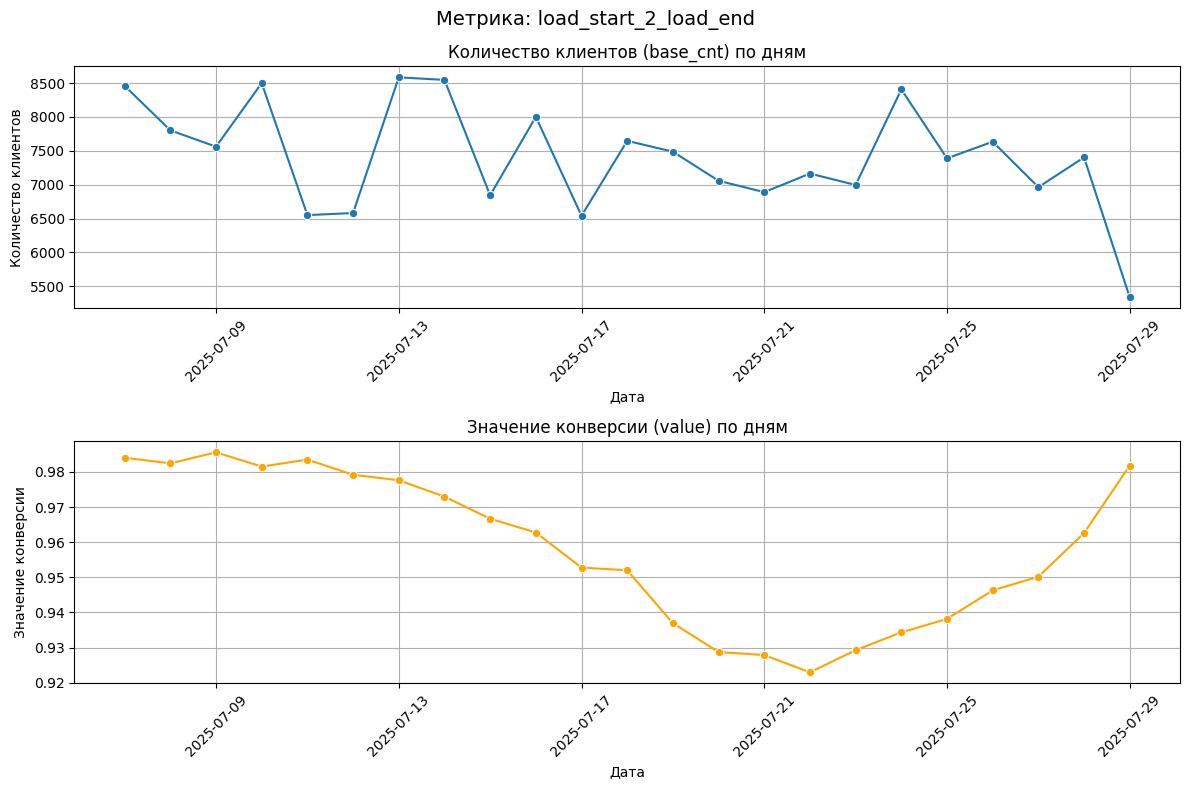

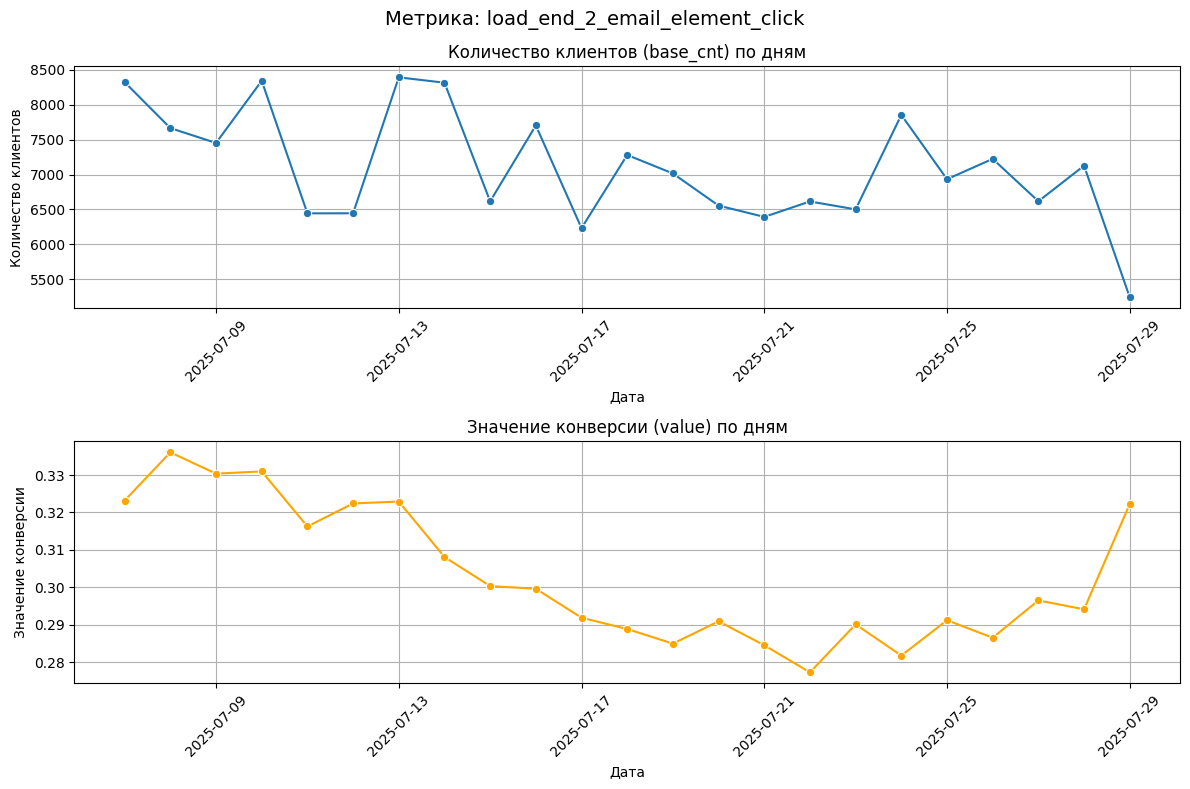

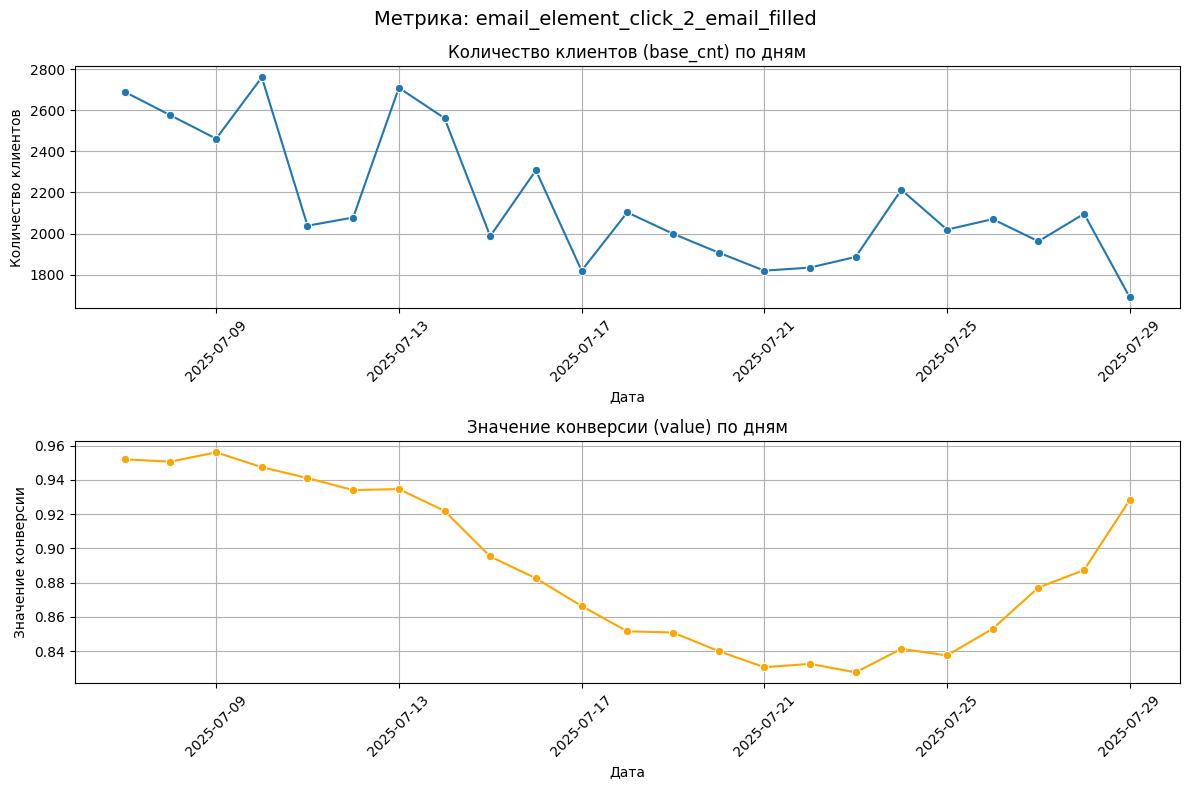

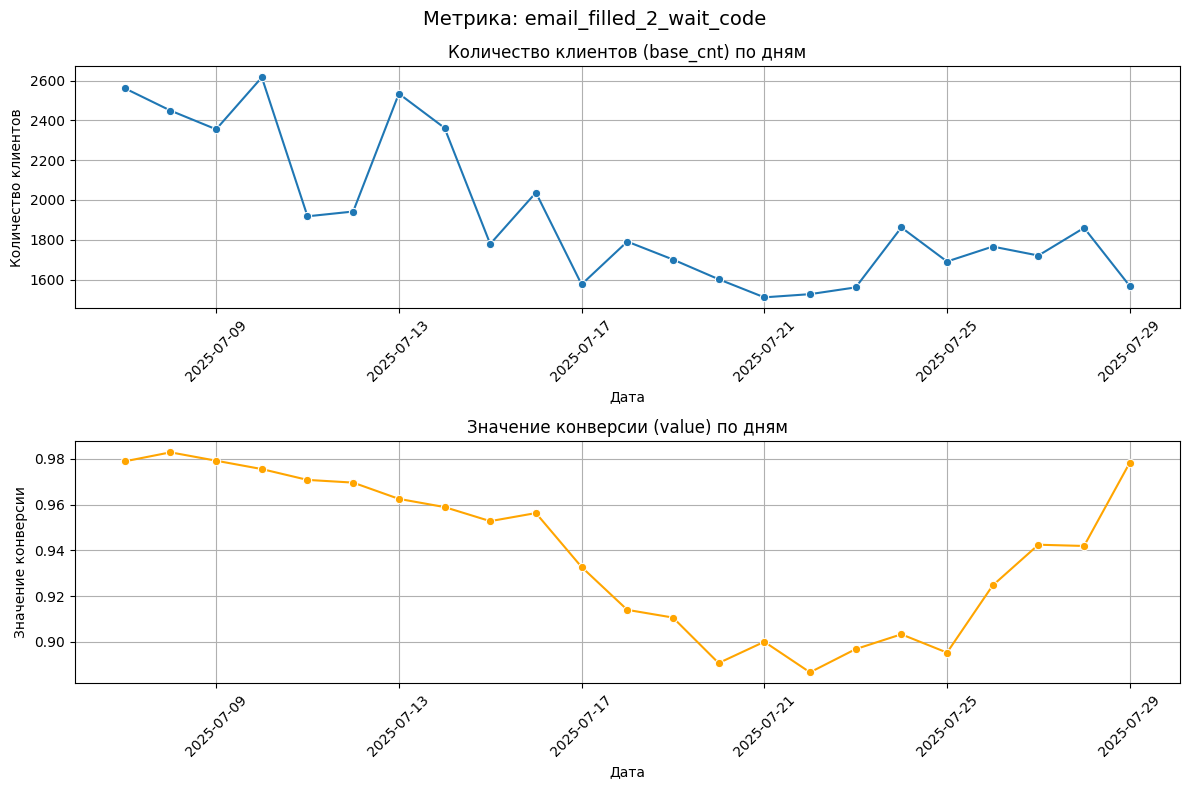

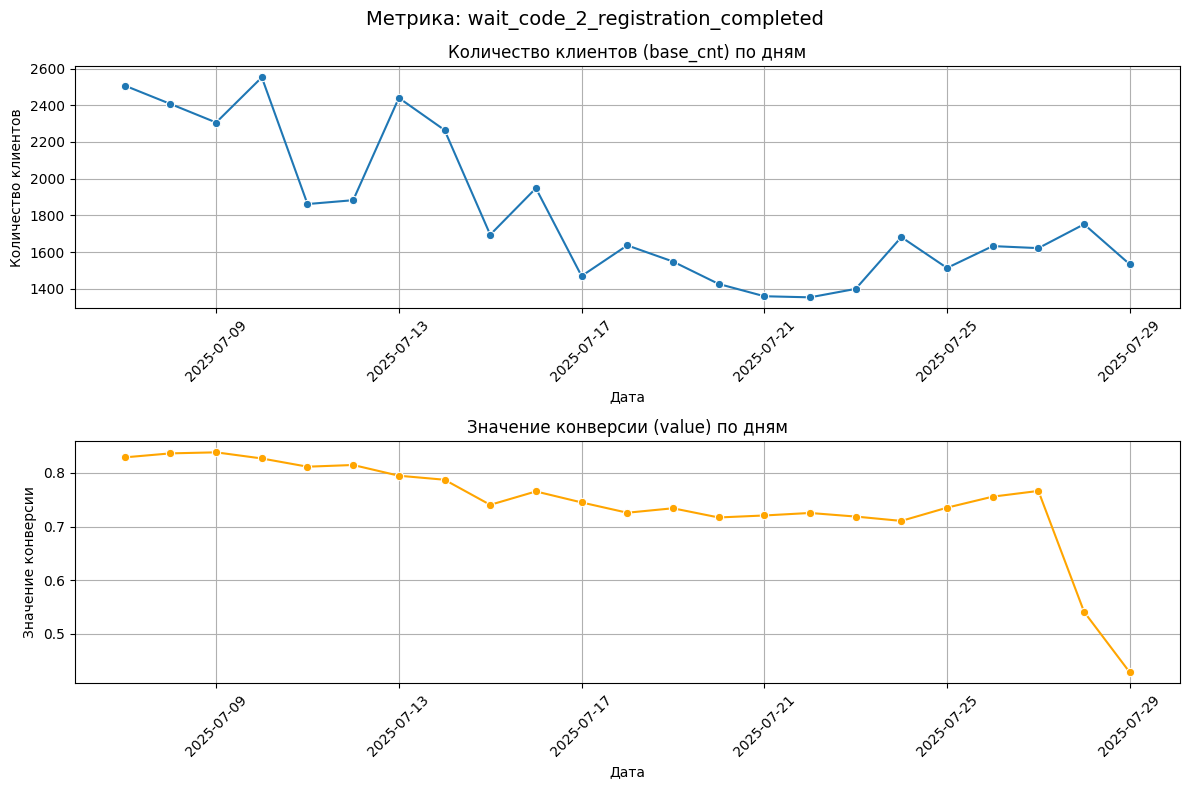

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Уникальные метрики в данных
metrics = conversion_df['metric'].unique()

# Создаем графики для каждой метрики
for metric in metrics:
    # Фильтруем данные по текущей метрике
    df_metric = conversion_df[conversion_df['metric'] == metric]
    
    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'Метрика: {metric}', fontsize=14)
    
    # График base_cnt по дням
    sns.lineplot(data=df_metric, x='date', y='base_cnt', ax=ax1, marker='o')
    ax1.set_title('Количество клиентов (base_cnt) по дням')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Количество клиентов')
    ax1.grid(True)
    
    # График value по дням
    sns.lineplot(data=df_metric, x='date', y='value', ax=ax2, marker='o', color='orange')
    ax2.set_title('Значение конверсии (value) по дням')
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Значение конверсии')
    ax2.grid(True)
    
    # Поворачиваем даты для лучшей читаемости
    for ax in [ax1, ax2]:
        plt.sca(ax)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [17]:
metric_1 = 'wait_code'
metric_2 = 'registration_completed'

df['hour'] = df.time.dt.floor('h')

In [18]:
df_last_days = df[df.time>'2025-07-25 00:00:00']

In [19]:
conv_name = metric_1 + '_2_' + metric_2

join_cols = ['device_id','hour']

base_df = df_last_days[df_last_days.event == metric_1][join_cols].drop_duplicates()
target_df = df_last_days[df_last_days.event == metric_2][join_cols].drop_duplicates()

base_df['base_cnt'] = 1
target_df['value'] = 1

metric_conv = base_df.merge(target_df,on=join_cols, how ='left').fillna(0)

metric_conv['metric'] = conv_name

metric_conv_agg = metric_conv.groupby(['hour','metric']).agg({'base_cnt':'count','value':'mean'}).reset_index()

In [20]:
metric_conv_agg

,hour,metric,base_cnt,value
0,2025-07-25 00:00:00,wait_code_2_registration_completed,2,0.500000
1,2025-07-25 01:00:00,wait_code_2_registration_completed,3,0.333333
2,2025-07-25 02:00:00,wait_code_2_registration_completed,2,1.000000
3,2025-07-25 03:00:00,wait_code_2_registration_completed,1,1.000000
4,2025-07-25 04:00:00,wait_code_2_registration_completed,2,0.500000
...,...,...,...,...
107,2025-07-29 14:00:00,wait_code_2_registration_completed,153,0.437908
108,2025-07-29 15:00:00,wait_code_2_registration_completed,144,0.423611
109,2025-07-29 16:00:00,wait_code_2_registration_completed,148,0.439189
110,2025-07-29 17:00:00,wait_code_2_registration_completed,156,0.448718


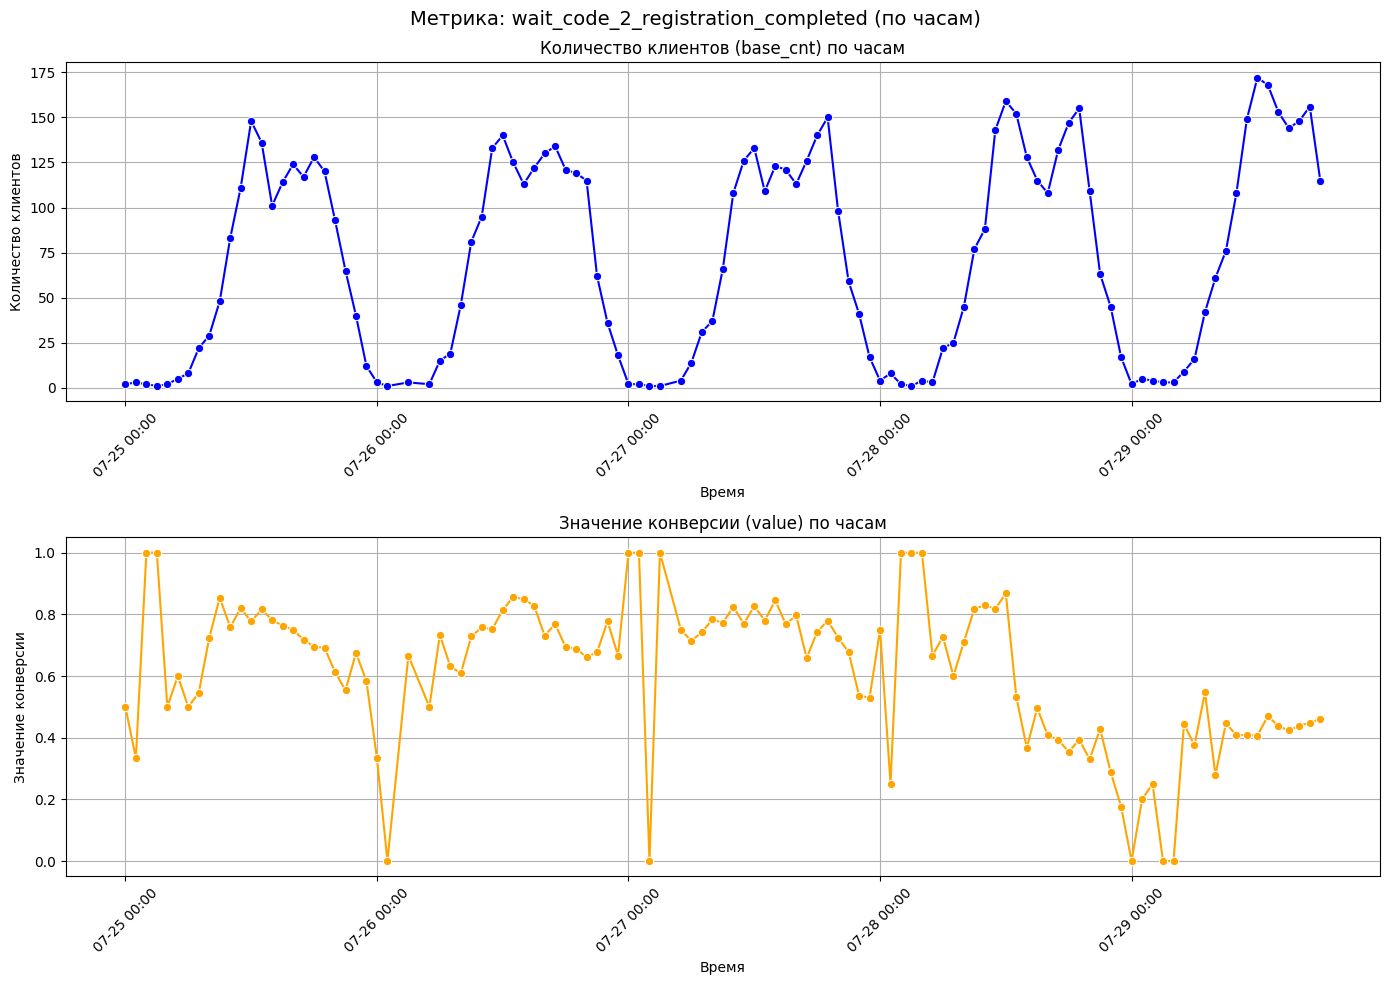

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Фильтруем данные по нужной метрике (если в данных есть другие метрики)
df_metric = metric_conv_agg[metric_conv_agg['metric'] == 'wait_code_2_registration_completed']

# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Метрика: wait_code_2_registration_completed (по часам)', fontsize=14)

# График base_cnt по часам
sns.lineplot(data=df_metric, x='hour', y='base_cnt', ax=ax1, marker='o', color='blue')
ax1.set_title('Количество клиентов (base_cnt) по часам')
ax1.set_xlabel('Время')
ax1.set_ylabel('Количество клиентов')
ax1.grid(True)

# Форматирование оси времени для лучшего отображения
date_format = DateFormatter("%m-%d %H:%M")
ax1.xaxis.set_major_formatter(date_format)

# График value по часам
sns.lineplot(data=df_metric, x='hour', y='value', ax=ax2, marker='o', color='orange')
ax2.set_title('Значение конверсии (value) по часам')
ax2.set_xlabel('Время')
ax2.set_ylabel('Значение конверсии')
ax2.grid(True)
ax2.xaxis.set_major_formatter(date_format)

# Поворачиваем даты для лучшей читаемости
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

In [22]:
metric_conv_agg.tail(40)

,hour,metric,base_cnt,value
72,2025-07-28 03:00:00,wait_code_2_registration_completed,1,1.000000
73,2025-07-28 04:00:00,wait_code_2_registration_completed,4,1.000000
74,2025-07-28 05:00:00,wait_code_2_registration_completed,3,0.666667
75,2025-07-28 06:00:00,wait_code_2_registration_completed,22,0.727273
76,2025-07-28 07:00:00,wait_code_2_registration_completed,25,0.600000
77,2025-07-28 08:00:00,wait_code_2_registration_completed,45,0.711111
78,2025-07-28 09:00:00,wait_code_2_registration_completed,77,0.818182
79,2025-07-28 10:00:00,wait_code_2_registration_completed,88,0.829545
80,2025-07-28 11:00:00,wait_code_2_registration_completed,143,0.818182
81,2025-07-28 12:00:00,wait_code_2_registration_completed,159,0.867925


### 5. Сделать вывод, есть ли падение и на каком этапе

Cудя по всему, падение кол-ва успешных регистраций происходит на этапе ожидания кода подтверждения email пользователя. 

Возможно из-за обновления сайта или технического сбоя с 28 июля клиентам начали нестабильно приходить коды подтверждения электронной почты, из-за чего не получалось успешно завершить регистрацию.